In [1]:
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import (LinearSVC, SVC)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

### PREPROCESSING

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train['label'].value_counts()

unrelated    175598
agreed        74238
disagreed      6606
Name: label, dtype: int64

In [4]:
def process(title):
    # Define punctuation marks to remove
    punctuations = string.punctuation.replace("#", "").replace("@", "")
    # Convert to lowercase
    title = title.lower()
    # Remove punctuation marks
    title = "".join([c for c in title if c not in punctuations])
    # Replace dashes with spaces
    title = title.replace("-", " ")
    # Remove extra spaces
    title = " ".join(title.split())
    # Tokenize into words
    words = word_tokenize(title)
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    # Join words back into a string
    title = " ".join(words)
    return title

In [5]:
print(train['title1_en'][1])
print(process(train['title1_en'][1]))

"If you do not come to Shenzhen, sooner or later your son will also come." In less than 10 years, Shenzhen per capita GDP will exceed Hong Kong.
if you do not come to shenzhen sooner or later your son will also come in le than 10 year shenzhen per caput gdp will exceed hong kong


In [6]:
train['title1'] = train['title1_en'].apply(process)
train['title2'] = train['title2_en'].apply(process)
test['title1'] = test['title1_en'].apply(process)
test['title2'] = test['title2_en'].apply(process)

In [7]:
print(train[['title1', 'title2', 'label']])
print(test[['title1','title2']])

                                                   title1  \
0       there are two new oldage insurance benefit for...   
1       if you do not come to shenzhen sooner or later...   
2       if you do not come to shenzhen sooner or later...   
3       if you do not come to shenzhen sooner or later...   
4       if you do not come to shenzhen sooner or later...   
...                                                   ...   
256437  egypt s presidential election failed to win mi...   
256438  egypt s presidential election failed to win mi...   
256439  egypt s presidential election failed to win mi...   
256440  egypt s presidential election failed to win mi...   
256441  will the united state wage war on iraq without...   

                                                   title2      label  
0       police disprove bird nest congress each person...  unrelated  
1       shenzhens gdp outstrips hong kong shenzhen sta...  unrelated  
2       the gdp overtopped hong kong shenzhen clarifie

In [8]:
train.to_csv('TRAIN.csv', index = False)
test.to_csv('TEST.csv', index = False)

In [9]:
TRAIN = pd.read_csv('TRAIN.csv')
TEST = pd.read_csv('TEST.csv')

# remove na titles
TRAIN = TRAIN[TRAIN['title1'].notna()]
TRAIN = TRAIN[TRAIN['title2'].notna()]
TRAIN_LABEL = TRAIN['label']
TEST['title1'] = TEST['title1'].fillna("0")
TEST['title2'] = TEST['title2'].fillna("0")

### MODELING

In [10]:
# 80% train and 20% Validation data from TRAIN dataset
train, validation, train_label, validation_label = train_test_split(TRAIN[['title1', 'title2']], TRAIN['label'], 
                                                            test_size = 0.2, random_state = 52, 
                                                            stratify = TRAIN['label'])

In [11]:
train_label.value_counts()

unrelated    140462
agreed        59381
disagreed      5284
Name: label, dtype: int64

In [12]:
data = TRAIN['title1'].tolist() + TRAIN['title2'].tolist() + TEST['title1'].tolist() + TEST['title2'].tolist()
count_vect = CountVectorizer()
count = count_vect.fit_transform(data)
vocabulary = count_vect.get_feature_names()
count_vect = CountVectorizer(vocabulary=vocabulary)

C:\Users\Pavani Rangineni\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
train_tl1 = count_vect.fit_transform(train['title1'])
train_tl2 = count_vect.fit_transform(train['title2'])
validation_tl1 = count_vect.fit_transform(validation['title1'])
validation_tl2 = count_vect.fit_transform(validation['title2'])

In [14]:
tf = TfidfTransformer()
train_tl1_tf = tf.fit_transform(train_tl1)
train_tl2_tf = tf.fit_transform(train_tl2)
validation_tl1_tf = tf.fit_transform(validation_tl1)
validation_tl2_tf = tf.fit_transform(validation_tl2)

In [15]:
TF_TRAIN = sparse.hstack([train_tl1_tf, train_tl2_tf])
TF_VALIDATION = sparse.hstack([validation_tl1_tf, validation_tl2_tf])

In [16]:
clf_NB = MultinomialNB()
clf_NB.fit(TF_TRAIN, train_label)
validation_pred = clf_NB.predict(TF_VALIDATION)
print('Multinomial Naive Bayes Accuracy:', clf_NB.score(TF_VALIDATION, validation_label), '| F1 Score:', f1_score(validation_label, validation_pred, average = 'weighted'))

Multinomial Naive Bayes Accuracy: 0.7652002652002652 | F1 Score: 0.7445996048891391


Precision: 0.7584559192896357
Recall: 0.7652002652002652


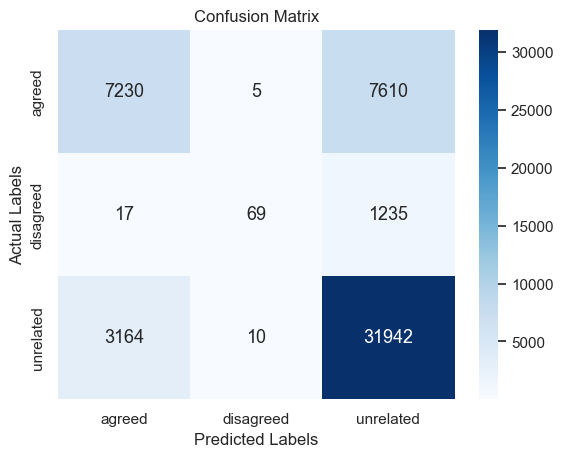

In [17]:
# Metrics for multi-dimensional Navie Bayes
precision = precision_score(validation_label, validation_pred, average = 'weighted')
recall = recall_score(validation_label, validation_pred, average = 'weighted')
conf_matrix = confusion_matrix(validation_label, validation_pred)
print('Metrics for Multi-Dimensional Navie Bayes: ')
print('Precision:', precision)
print('Recall:', recall)
sns.set(font_scale= 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 13}, cmap='Blues', 
            xticklabels = ['agreed', 'disagreed', 'unrelated'],
            yticklabels = ['agreed', 'disagreed', 'unrelated'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [18]:
clf_SVC = LinearSVC(class_weight = 'balanced', random_state = 52, max_iter = 1000)
clf_SVC.fit(TF_TRAIN, train_label)
validation_pred = clf_SVC.predict(TF_VALIDATION)
print('SVC Accuracy:', clf_SVC.score(TF_VALIDATION, validation_label), '| F1 Score:', f1_score(validation_label, validation_pred, average = 'weighted'))

SVC Accuracy: 0.8029133029133029 | F1 Score: 0.8057666719625504


Precision: 0.8106947453247599
Recall: 0.8029133029133029


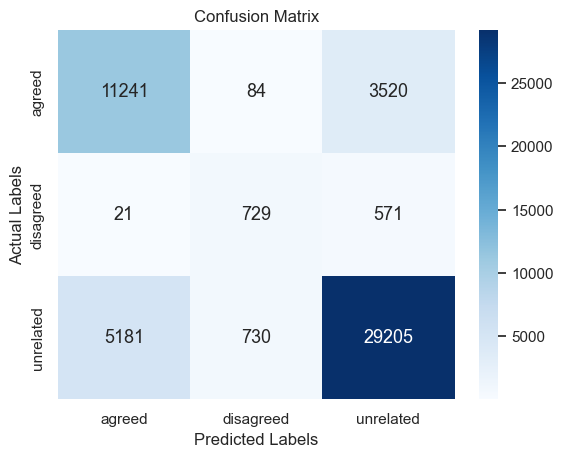

In [19]:
# Metrics for Support Vector classifier
precision = precision_score(validation_label, validation_pred, average = 'weighted')
recall = recall_score(validation_label, validation_pred, average = 'weighted')
conf_matrix = confusion_matrix(validation_label, validation_pred)
print('Metrics for Support Vector Classifier: ')
print('Precision:', precision)
print('Recall:', recall)
sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 13}, cmap='Blues', 
            xticklabels = ['agreed', 'disagreed', 'unrelated'],
            yticklabels = ['agreed', 'disagreed', 'unrelated'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [20]:
clf_LGSTR = LogisticRegression(class_weight = 'balanced', random_state = 52, max_iter = 500)
clf_LGSTR.fit(TF_TRAIN, train_label)
validation_pred = clf_LGSTR.predict(TF_VALIDATION)
print('Logistic Regression Accuracy:', clf_LGSTR.score(TF_VALIDATION, validation_label), '| F1 Score:', f1_score(validation_label, validation_pred, average = 'weighted'))

Logistic Regression Accuracy: 0.745095745095745 | F1 Score: 0.7573582512243484


Precision: 0.7993667365763544
Recall: 0.745095745095745


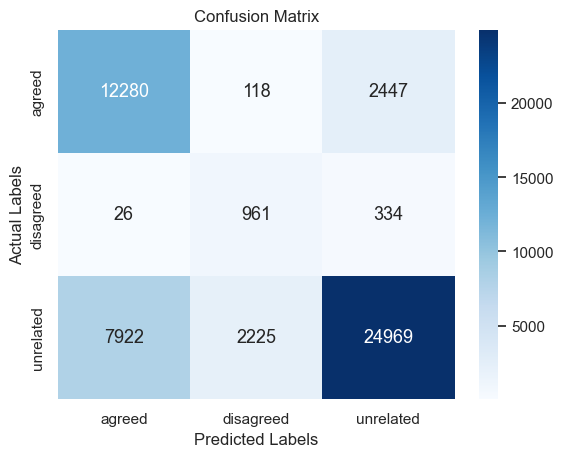

In [21]:
# Metrics for Logistic Regression
precision = precision_score(validation_label, validation_pred, average = 'weighted')
recall = recall_score(validation_label, validation_pred, average = 'weighted')
conf_matrix = confusion_matrix(validation_label, validation_pred)
print('Metrics for Logistic Regression: ')
print('Precision:', precision)
print('Recall:', recall)
sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 13}, cmap='Blues', 
            xticklabels = ['agreed', 'disagreed', 'unrelated'],
            yticklabels = ['agreed', 'disagreed', 'unrelated'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [22]:
clf_RF = RandomForestClassifier(random_state = 52)
clf_RF.fit(TF_TRAIN, train_label)
validation_pred = clf_RF.predict(TF_VALIDATION)
print('Random Forest Accuracy:', clf_RF.score(TF_VALIDATION, validation_label), '| F1 Score:', f1_score(validation_label, validation_pred, average = 'weighted'))

Random Forest Accuracy: 0.8397098397098397 | F1 Score: 0.8271402675784431


Precision: 0.8431948409638297
Recall: 0.8397098397098397


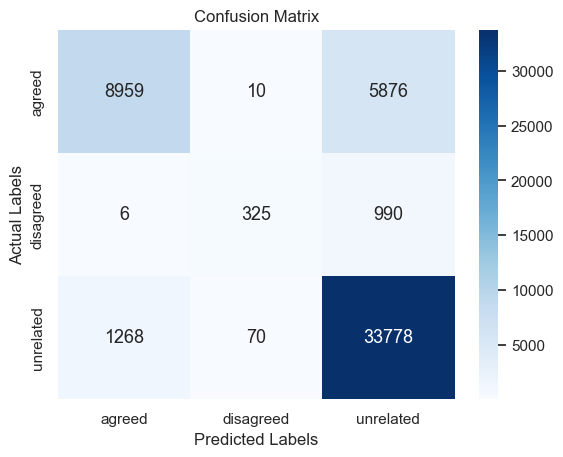

In [23]:
# Metrics for Random Forest
precision = precision_score(validation_label, validation_pred, average = 'weighted')
recall = recall_score(validation_label, validation_pred, average = 'weighted')
conf_matrix = confusion_matrix(validation_label, validation_pred)
print('Metrics for Random Forest: ')
print('Precision:', precision)
print('Recall:', recall)
sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 13}, cmap='Blues', 
            xticklabels = ['agreed', 'disagreed', 'unrelated'],
            yticklabels = ['agreed', 'disagreed', 'unrelated'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [24]:
validation_label.value_counts()

unrelated    35116
agreed       14845
disagreed     1321
Name: label, dtype: int64

In [25]:
# Submission File is done by using Random Forest has it has highest accuracy
TEST_tl1 = count_vect.fit_transform(TEST['title1'])
TEST_tl2 = count_vect.fit_transform(TEST['title2'])
TEST_tl1_tf = tf.fit_transform(TEST_tl1)
TEST_tl2_tf = tf.fit_transform(TEST_tl2)
TF_TEST = sparse.hstack([TEST_tl1_tf, TEST_tl2_tf])
TEST_PRED = clf_RF.predict(TF_TEST)
TEST['label'] = TEST_PRED
print(TEST_PRED)

['unrelated' 'unrelated' 'unrelated' ... 'agreed' 'unrelated' 'unrelated']


In [26]:
TEST

,id,tid1,tid2,title1_en,title2_en,title1,title2,label
0,256442,100672,100673,"The great coat brother Zhu Zhu Wen, in the man...","Lin xinsheng after the birth of ""hard milking,...",the great coat brother zhu zhu wen in the mand...,lin xinsheng after the birth of hard milking h...,unrelated
1,256443,162269,162270,NASA reveals facts about UFO wreckage found on...,"The UFO found in Yuancun, Jiaocheng County, Sh...",nasa reveals fact about ufo wreckage found on ...,the ufo found in yuancun jiaocheng county shan...,unrelated
2,256444,157826,157854,The hollow tomatoes are loaded with hormones.,"Li chenfan bingbing home photos, netizen: this...",the hollow tomato are loaded with hormone,li chenfan bingbing home photo netizen this is...,unrelated
3,256445,109579,74076,Ange Pavilion Geoshui: How accurate is Matrimo...,Master one: the eight-character presumption of...,ange pavilion geoshui how accurate is matrimon...,master one the eightcharacter presumption of m...,unrelated
4,256446,15068,15085,A 50-year-old bus-bus blows up an 8-year-old c...,< i > Joe Johnson's disgruntled timing and ord...,a 50yearold busbus blow up an 8yearold child r...,i joe johnson disgruntled timing and order wa ...,unrelated
...,...,...,...,...,...,...,...,...
64105,320547,94862,94863,The lead content of domestic faucet exceeds th...,"The multi-brand faucet is overtaxed, who is en...",the lead content of domestic faucet exceeds th...,the multibrand faucet is overtaxed who is enda...,unrelated
64106,320548,7451,7452,"In 2018, the household registration system has...","In 2018, the household registration system wil...",in 2018 the household registration system ha c...,in 2018 the household registration system will...,agreed
64107,320549,144163,144164,"Onion can not be eaten with this, serious also...","Onion can not eat with this, serious also can ...",onion can not be eaten with this serious also ...,onion can not eat with this serious also can c...,agreed
64108,320550,96842,96856,"Grass-root teacher salaries, the last increase...","Teachers wage reform, there will be these thre...",grassroot teacher salary the last increase bef...,teacher wage reform there will be these three ...,unrelated


In [27]:
submission = TEST[['id', 'label']]
submission.to_csv('submission.csv', index = False)

### TESTING

In [37]:
# Define the TF-IDF vectorizer with stop words and n-gram range of 2-4
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2, 4))

# Extract n-grams from 'title1' column of TRAIN
features1 = tfidf.fit_transform(TRAIN['title1'])
labels = TRAIN_LABEL

# Extract the most correlated n-grams for each label using chi-squared test
best_grams = []
for lb in [0, 1, 2]:
    chi2_scores = chi2(features1, labels == lb)
    sorted_indices = np.argsort(chi2_scores[0])
    top_features = np.array(tfidf.get_feature_names())[sorted_indices][-20:]
    best_grams.extend(top_features) 

# Extract n-grams from 'title2' column of TRAIN
features2 = tfidf.fit_transform(TRAIN['title2'])

# Extract the most correlated n-grams for each label using chi-squared test
for lb in [0, 1, 2]:
    chi2_scores = chi2(features2, labels == lb)
    sorted_indices = np.argsort(chi2_scores[0])
    top_features = np.array(tfidf.get_feature_names())[sorted_indices][-20:]
    best_grams.extend(top_features)
    
# Print the list of most correlated n-grams for all labels
print(best_grams, '\n')

C:\Users\Pavani Rangineni\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Pavani Rangineni\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Pavani Rangineni\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Pavani Rangineni\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Func

['flotsam distance looking', 'flotsam distance looking disc', 'flotsam fast', 'flotsam fast track', 'flotsam fast track quickly', 'flotsam really', 'flotsam really help', 'flotsam really help propagandize', 'flotsam threeyearold', 'flotsam threeyearold witkowski', 'flotsam threeyearold witkowski said', 'flour 90', 'flour 90 time', 'flour 90 time toxic', 'flour breakdown', 'flour breakdown product', 'flour breakdown product 90', 'flour clear', 'flow 10 time instantly', '泸州娃 trouser leg habit', 'flotsam distance looking', 'flotsam distance looking disc', 'flotsam fast', 'flotsam fast track', 'flotsam fast track quickly', 'flotsam really', 'flotsam really help', 'flotsam really help propagandize', 'flotsam threeyearold', 'flotsam threeyearold witkowski', 'flotsam threeyearold witkowski said', 'flour 90', 'flour 90 time', 'flour 90 time toxic', 'flour breakdown', 'flour breakdown product', 'flour breakdown product 90', 'flour clear', 'flow 10 time instantly', '泸州娃 trouser leg habit', 'flot

In [29]:
features[0,1]

0.0

In [30]:
np.c_[train_tl1, train_tl2]

array([[<205127x46693 sparse matrix of type '<class 'numpy.int64'>'
        	with 2905630 stored elements in Compressed Sparse Row format>,
        <205127x46693 sparse matrix of type '<class 'numpy.int64'>'
        	with 2933156 stored elements in Compressed Sparse Row format>]],
      dtype=object)

In [31]:
t = train_tl1[:]

In [32]:
train_fe = TF_TRAIN.copy()
test_fe = TF_TEST.copy()

In [33]:
train_fe

<205127x93386 sparse matrix of type '<class 'numpy.float64'>'
	with 5838786 stored elements in Compressed Sparse Row format>

In [34]:
validation_tl2[0]

<1x46693 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [35]:
validation_tl2[0, 39386]

0

In [36]:
# similarity of sentences - cosine similarity
cos_train = []
cos_test = []
for i in range(train_fe.shape[0]):
    #cos.append(cosine_similarity(title1_train[i], title2_train[i])[0][0])
    cos_train.append(1)
for i in range(test_fe.shape[0]):
    #cos.append(cosine_similarity(title1_test[i], title2_test[i])[0][0])
    cos_test.append(1)
# Check the dimensions of train_fe and test_fe
print(train_fe.shape)
print(test_fe.shape)
print(len(cos_train))
print(len(cos_test))

train_fe_new = sparse.hstack([train_fe, sparse.csr_matrix(cos_train).T])
test_fe_new = sparse.hstack([test_fe, sparse.csr_matrix(cos_test).T])

# Check the dimensions of the new sparse matrices
print(train_fe_new.shape)
print(test_fe_new.shape)

(205127, 93386)
(64110, 93386)
205127
64110
(205127, 93387)
(64110, 93387)
